In [453]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np



Goal of the project and the challenges. 

In [454]:
df = pd.read_csv("data.csv")
df.head(2)

,STATION ID,STATION NAME,DATE,DAILY AVG TEMP (DEG F),DAILY MAX TEMP (DEG F),DAILY MIN TEMP (DEG F),DAILY PRECIPITATION TOTAL (INCHES)
0,USW00093821,"LOUISVILLE INTERNATIONAL AIRPORT, KY US",1/1/48,44.5,62.0,27.0,1.28
1,USW00093821,"LOUISVILLE INTERNATIONAL AIRPORT, KY US",1/2/48,30.5,35.0,26.0,0.00


In [455]:
df = df.drop(['STATION ID'], axis=1)
df = df.rename(columns = {"STATION NAME":'Station', 
                          'DATE': 'Date', 
                          "DAILY AVG TEMP (DEG F)" : "Average_Temp", 
                          "DAILY MAX TEMP (DEG F)" : "Max_Temp",	
                          "DAILY MIN TEMP (DEG F)" : "Min_Temp",	
                          "DAILY PRECIPITATION TOTAL (INCHES)" : "Rain_Fall"})
df.head(2)

,Station,Date,Average_Temp,Max_Temp,Min_Temp,Rain_Fall
0,"LOUISVILLE INTERNATIONAL AIRPORT, KY US",1/1/48,44.5,62.0,27.0,1.28
1,"LOUISVILLE INTERNATIONAL AIRPORT, KY US",1/2/48,30.5,35.0,26.0,0.00


In [456]:
# Split the 'Date' column into day, month, and year
df[['Month', 'Day', 'Year']] = df['Date'].str.split('/', expand=True)

df['Year'] = df['Year'].astype(int)

# Adjust the year based on the specified conditions
df['Year'] = df['Year'].apply(lambda x: x + 1900 
                              if 48 <= x <= 99 
                              else x + 2000 
                              if 0 <= x <= 23 
                              else x)

# Combine day, month, and corrected year into a new 'Date' column
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']], format='%Y-%m-%d', errors='coerce')

# Check the resulting 'Date' column
df['Date'].head(2)

0   1948-01-01
1   1948-01-02
Name: Date, dtype: datetime64[ns]

In [457]:

# Get decade from 'Date' and make new column 'Decade'
df['Decade'] = df['Date'].dt.year // 10 * 10

# Define how to aggregate
agg_functions = {
    'Date': 'first', 
    'Average_Temp': 'mean', 
    'Max_Temp': 'mean', 
    'Min_Temp': 'mean', 
    'Rain_Fall': 'mean'
}

# Group the data by 'Decade' and aggregate
df_decade = df.groupby(df['Decade']).agg(agg_functions)

# Reset the index to make 'Decade' a column
df_decade.reset_index(inplace=True)


# Round the columns to 2 decimal places
df_decade[['Average_Temp', 'Max_Temp', 'Min_Temp', 'Rain_Fall']] = df_decade[['Average_Temp', 'Max_Temp', 'Min_Temp', 'Rain_Fall']].round(2)

# remove 1940 and 2020 as they arent complete
df_decade = df_decade[(df_decade['Decade'] != 1940) & (df_decade['Decade'] != 2020)]

df_decade.head(20)


,Decade,Date,Average_Temp,Max_Temp,Min_Temp,Rain_Fall
1,1950,1950-01-01,57.07,67.52,46.63,0.12
2,1960,1960-01-01,55.34,65.54,45.14,0.11
3,1970,1970-01-01,56.33,65.85,46.81,0.13
4,1980,1980-01-01,56.67,66.44,46.90,0.11
5,1990,1990-01-01,57.90,67.43,48.53,0.12
6,2000,2000-01-01,58.32,67.50,49.14,0.13
7,2010,2010-01-01,59.42,68.79,50.06,0.14


In [458]:
# Get decade from 'Date' and make a new column 'Decade'
df['Decade'] = df['Date'].dt.year // 10 * 10

# Extract month from 'Date' and make a new column 'Month'
df['Month'] = df['Date'].dt.month

# Define how to aggregate
agg_functions = {
    'Date': 'first', 
    'Average_Temp': 'mean', 
    'Max_Temp': 'mean', 
    'Min_Temp': 'mean', 
    'Rain_Fall': 'mean'
}

# Group the data by 'Decade' and 'Month' and aggregate
df_monthly_decade = df.groupby(['Decade', 'Month']).agg(agg_functions)

# Reset the index to make 'Decade' and 'Month' columns
df_monthly_decade.reset_index(inplace=True)

# Round the columns to 2 decimal places
df_monthly_decade[['Average_Temp', 'Max_Temp', 'Min_Temp', 'Rain_Fall']] = df_monthly_decade[['Average_Temp', 'Max_Temp', 'Min_Temp', 'Rain_Fall']].round(2)

# Remove 1940 and 2020 as they are not complete
df_monthly_decade = df_monthly_decade[(df_monthly_decade['Decade'] != 1940) & (df_monthly_decade['Decade'] != 2020)]

# Display the resulting DataFrame
df_monthly_decade.head(3)


,Decade,Month,Date,Average_Temp,Max_Temp,Min_Temp,Rain_Fall
12,1950,1,1950-01-01,35.85,43.94,27.76,0.16
13,1950,2,1950-02-01,38.90,48.09,29.72,0.13
14,1950,3,1950-03-01,44.57,54.34,34.81,0.12


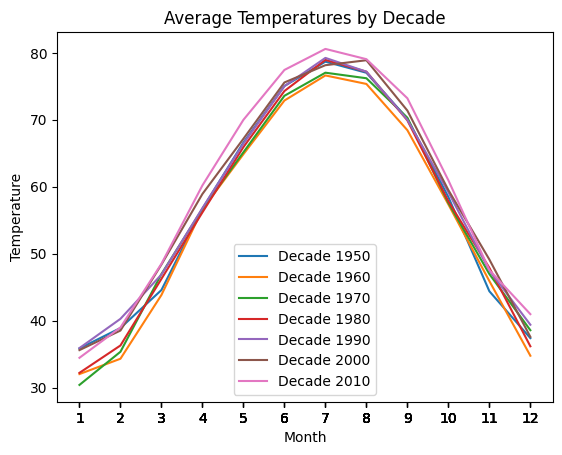

In [459]:
# Separate data by decades
decades = df_monthly_decade['Decade'].unique()

# Create a separate line for each decade
for decade in decades:
    subset = df_monthly_decade[df_monthly_decade['Decade'] == decade]
    plt.plot(subset['Month'], subset['Average_Temp'], label=f'Decade {decade}')

plt.legend()

# naming x axis
plt.xlabel('Month')

# naming y axis
plt.ylabel('Temperature')

# title to the graph
plt.title('Average Temperatures by Decade')

# x-axis labels 
plt.xticks(df_monthly_decade['Month'])

# Show the plot
plt.show()

# Data Modeling with Neural Prophet 

In [460]:
from neuralprophet import NeuralProphet
from matplotlib import pyplot as plt

Looking at the data as a whole

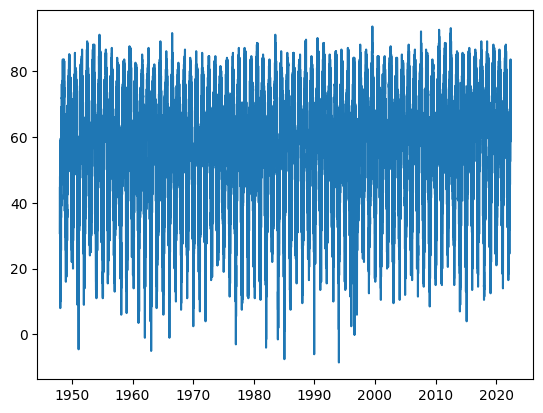

In [461]:
plt.plot(df ['Date'], df ['Average_Temp'])
plt.show()

Filtering out columns as Neural Prophet only takes two columns.
<br>
Date now being ds and the TempAvgF being y (yhat1 later).

In [462]:
# new_column = df[['Date', 'Average_Temp']] 
# new_column.dropna(inplace=True)
# new_column.columns = ['ds', 'y'] 
# new_column.tail()

This takes 49 mins to run on M1 MBA 
<br>
 Creating an instance of Neural Prophet using the NeuralProphet() class we imported earlier as n.  Then  used the fit() method to go ahead and train.

In [463]:
# n = NeuralProphet()
# model = n.fit(new_column, freq='D', epochs=5000)

Then ran predictions out to 2030 stored into a dataframe of forecasted.

In [464]:
# future = n.make_future_dataframe(new_column, periods=3132)
# forecast = n.predict(future)
# forecast.tail()

saves the model to csv to pull from later so the model doesnt have to run every time you want to see it. 

In [465]:
# forecast.to_csv('model.csv')
mdf = pd.read_csv('model.csv')
mdf.head()

,Unnamed: 0,ds,y,yhat1,trend,season_yearly,season_weekly
0,0,2022-06-05,NaN,74.763214,59.405842,15.456910,-0.099535
1,1,2022-06-06,NaN,75.244995,59.405128,15.736203,0.103666
2,2,2022-06-07,NaN,75.814041,59.404415,16.009836,0.399791
3,3,2022-06-08,NaN,76.128578,59.403706,16.277433,0.447438
4,4,2022-06-09,NaN,75.998543,59.402992,16.538643,0.056905


<Axes: xlabel='ds'>

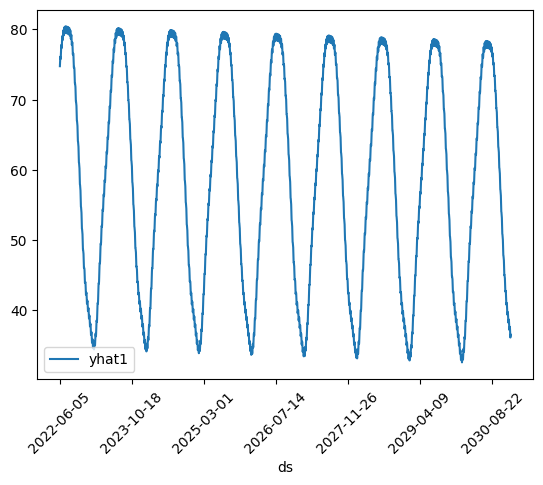

In [466]:
mdf.plot(x="ds", y="yhat1", rot= 45)

Gettting rid of extra columns to make the data frames match. 

In [468]:
columns_to_drop = ['Station', 'Max_Temp',	'Min_Temp',	'Rain_Fall',	'Month',	'Day',	'Year',	'Decade'] 
df = df.drop(columns_to_drop, axis=1)
df.head()

,Date,Average_Temp
0,1948-01-01,44.5
1,1948-01-02,30.5
2,1948-01-03,31.5
3,1948-01-04,34.5
4,1948-01-05,34.5


Renaming and getting rid of colums to match the original data frame. 

In [469]:
mdf.rename(columns={'ds': 'Date', 'yhat1': 'Average_Temp'}, inplace=True)
columns_to_drop = ['Unnamed: 0', 'y', 'trend', 'season_yearly',	'season_weekly'] 
mdf = mdf.drop(columns_to_drop, axis=1)
mdf.head()

,Date,Average_Temp
0,2022-06-05,74.763214
1,2022-06-06,75.244995
2,2022-06-07,75.814041
3,2022-06-08,76.128578
4,2022-06-09,75.998543


Combined the data frames to make a full set of data. 

In [470]:
modeled = pd.concat([df, mdf], ignore_index=True)
modeled.shape

(30316, 2)

Averages the new data to decades and uses a slice of the data for the new graph. 

In [471]:
# Get decade from 'Date' and make a new column 'Decade'
df['Decade'] = df['Date'].dt.year // 10 * 10

# Extract month from 'Date' and make a new column 'Month'
df['Month'] = df['Date'].dt.month

# Define how to aggregate
agg_functions = {
    'Date': 'first', 
    'Average_Temp': 'mean', 
}

# Group the data by 'Decade' and 'Month' and aggregate
df_monthly_decade = df.groupby(['Decade', 'Month']).agg(agg_functions)

# Reset the index to make 'Decade' and 'Month' columns
df_monthly_decade.reset_index(inplace=True)

# Round the columns to 2 decimal places
df_monthly_decade[['Average_Temp']] = df_monthly_decade[['Average_Temp']].round(2)

# limits the data to 1990 - 2030 
df_monthly_decade = df_monthly_decade[(df_monthly_decade['Decade'] >= 1990) & (df_monthly_decade['Decade'] <= 2030)]

# Display the resulting DataFrame
df_monthly_decade.head(3)

,Decade,Month,Date,Average_Temp
60,1990,1,1990-01-01,35.90
61,1990,2,1990-02-01,40.27
62,1990,3,1990-03-01,46.88


Graphs the new modeled data. 

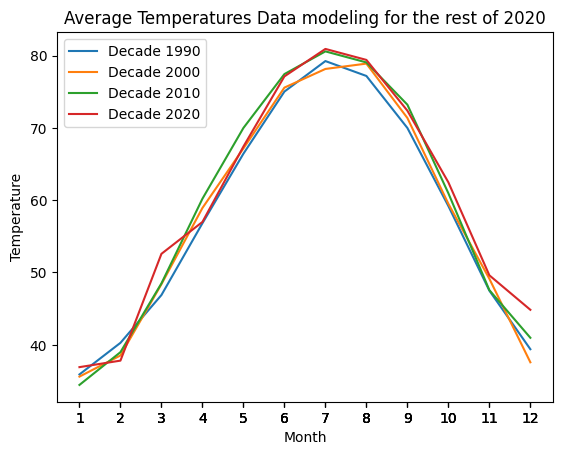

In [472]:
# Separate data by decades
decades = df_monthly_decade['Decade'].unique()

# Create a separate line for each decade
for decade in decades:
    subset = df_monthly_decade[df_monthly_decade['Decade'] == decade]
    plt.plot(subset['Month'], subset['Average_Temp'], label=f'Decade {decade}')

plt.legend()

# naming x axis
plt.xlabel('Month')

# naming y axis
plt.ylabel('Temperature')

# title to the graph
plt.title('Average Temperatures Data modeling for the rest of 2020')

# x-axis labels 
plt.xticks(df_monthly_decade['Month'])

# Show the plot
plt.show()

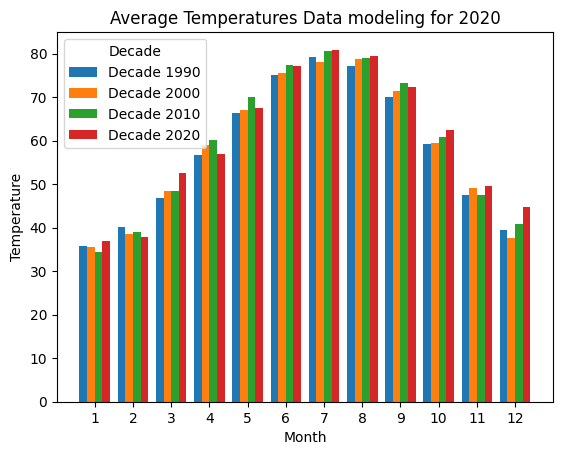

In [473]:
# Separate data by decades
decades = df_monthly_decade['Decade'].unique()

# Set the width of the bars
bar_width = 0.2

# Create an array of month indices for x-axis positioning
month_indices = df_monthly_decade['Month'].unique()

# Create a bar for each decade
for i, decade in enumerate(decades):
    subset = df_monthly_decade[df_monthly_decade['Decade'] == decade]
    plt.bar(month_indices + i * bar_width, subset['Average_Temp'], width=bar_width, label=f'Decade {decade}')

# naming x axis
plt.xlabel('Month')

# naming y axis
plt.ylabel('Temperature')

# title to the graph
plt.title('Average Temperatures Data modeling for 2020')

# Set x-axis ticks and labels
plt.xticks(month_indices + (bar_width * (len(decades) - 1)) / 2, df_monthly_decade['Month'].unique())

# Add a legend
plt.legend(title='Decade')

# Show the plot
plt.show()